In [1]:
# import numpy as np
import autograd.numpy as np
from autograd import grad
import matplotlib 
import matplotlib as mpl
import fitsio
import os, glob

import halophot
from halophot.halo_tools import *
from k2sc import cdpp 

%pylab inline --no-import-all
from autograd import numpy as np 

matplotlib.rcParams['image.origin'] = 'lower'
matplotlib.rcParams['figure.figsize']=(10.0,10.0)    #(6.0,4.0)
matplotlib.rcParams['font.size']=16              #10 
matplotlib.rcParams['savefig.dpi']= 300             #72 
matplotlib.rcParams['axes.facecolor']='white'
matplotlib.rcParams['savefig.facecolor']='white'

colours = mpl.rcParams['axes.color_cycle'] 


Populating the interactive namespace from numpy and matplotlib


/Users/benjaminpope/anaconda2/lib/python2.7/site-packages/matplotlib/__init__.py:830: MatplotlibDeprecationWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  mplDeprecation)


In [2]:
# ls /Users/benjaminpope/Dropbox/TRES3_CLUSTER/0_CLEAN
fnames = glob.glob('/Users/benjaminpope/Dropbox/TRES3_CLUSTER/0_CLEAN/*.fits')
fnames = np.sort(fnames)
# for name in fnames:
#     print name


In [3]:
tpf = np.zeros((50,50,len(fnames)))
tpf_calib = np.zeros((50,50,len(fnames)))

for j, fname in enumerate(fnames):
    f = fitsio.FITS(fname)
    image = f[0][:,:]
    target = image[872:922,390:440]
    calib = image[625:675,862:912]
    tpf[:,:,j] = target
    tpf_calib[:,:,j] = calib

tpf = tpf[:,:,:400]
tpf_calib = tpf_calib[:,:,:400]

Text(0.5,1.01,u'Extremely Raw Photometry of TRES-3b')

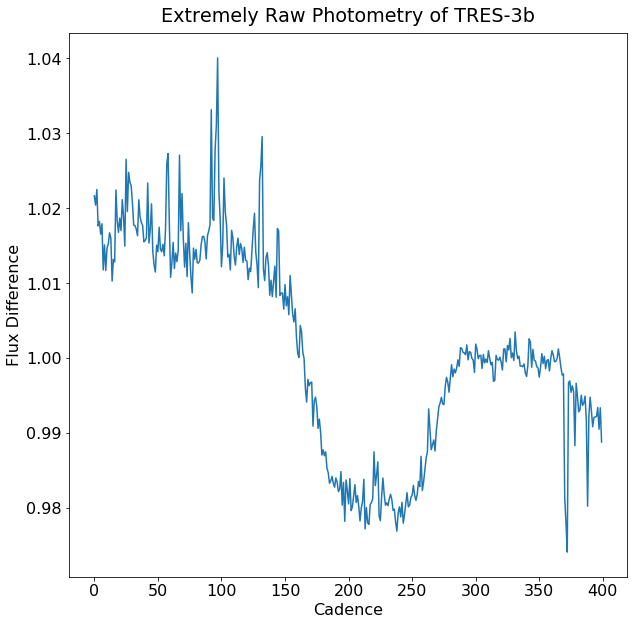

In [4]:
lc = np.sum(tpf,axis=(0,1))
cal = np.sum(tpf_calib,axis=(0,1))
# plt.plot(lc)
# plt.plot(cal)
final = lc-cal
final /= np.nanmedian(final)
plt.plot(2-(final))
plt.xlabel("Cadence")
plt.ylabel("Flux Difference")
plt.title("Extremely Raw Photometry of TRES-3b",y=1.01)

## Exploratory Image Analysis



In [5]:
f = fitsio.FITS(fnames[0])
image = f[0][:,:]

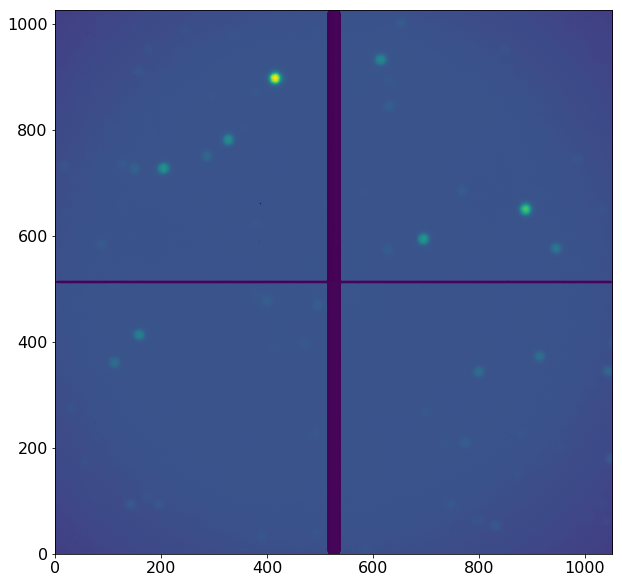

In [6]:
plt.imshow(image**0.5,interpolation="None")

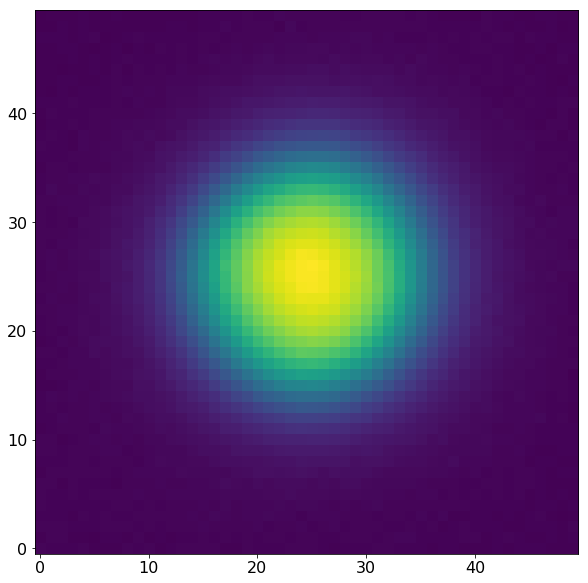

In [7]:
f = fitsio.FITS(fnames[0])
image = f[0][:,:]
plt.imshow(image[872:922,390:440]**0.5)

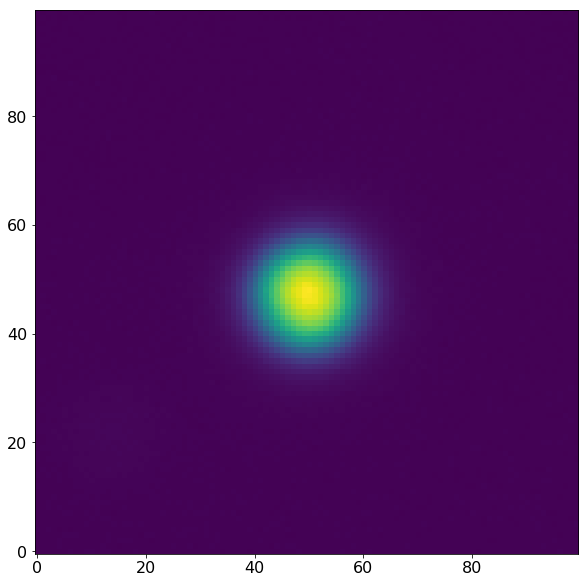

In [8]:
target = image[850:950,365:465]
plt.imshow(target,interpolation="None")

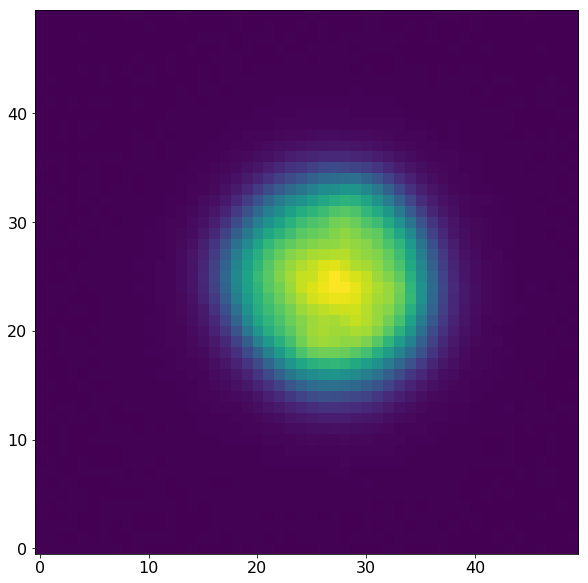

In [9]:
plt.imshow(tpf[:,:,-1],interpolation="none")

In [10]:
# import imageio
# to_write = [(tpf[:,:,j]/np.float(np.max(tpf[:,:,j])))**0.5 *256 for j in range(tpf.shape[2])]
# imageio.mimwrite('diffuser_video.mp4', to_write, fps = 64)


## Now to try Halo



In [11]:
ncad = tpf.shape[2]
nx, ny = tpf.shape[0], tpf.shape[1]
npix = nx*ny

pixelvectors = 1.*np.reshape(tpf,(nx*ny,ncad))
pixelvectors_calib = 1.*np.reshape(tpf_calib,(nx*ny,ncad))


In [12]:
def softmax(x):
    '''From https://gist.github.com/stober/1946926'''
    e_x = np.exp(x - np.max(x))
    out = e_x / e_x.sum()
    return out

In [13]:
def obj_1_soft(weights,pixelvec):
    flux = np.dot(softmax(weights).T,pixelvec)
    diff = np.sum(np.abs(flux[1:] - flux[:-1]))
    return diff/np.mean(flux)

gradient = grad(obj_1_soft,argnum=0)

In [14]:
# cons = ({'type': 'eq', 'fun': lambda z: z.sum() - 1.})
# bounds = (npix)*((0,1),)

w_init = np.random.rand(npix)
w_init /= np.sum(w_init)

# obj_1_soft(w_init)
# print gradient(w_init)

In [35]:
%%time

maxiter = 101
res = optimize.minimize(obj_1_soft, w_init, args=(pixelvectors), method='L-BFGS-B', jac=gradient, 
    options={'disp': False,'maxiter':maxiter})

w_best = softmax(res['x']) # softmax

lc_opt_science = np.dot(w_best,pixelvectors)
# lc_opt_science /= np.nanmean(lc_opt_science)

CPU times: user 459 ms, sys: 13.1 ms, total: 472 ms
Wall time: 369 ms


In [38]:
%%time

maxiter = 101
res = optimize.minimize(obj_1_soft, w_init, args=(pixelvectors_calib), method='L-BFGS-B', jac=gradient, 
    options={'disp': False,'maxiter':maxiter})

w_best = softmax(res['x']) # softmax

lc_opt_calib = np.dot(w_best,pixelvectors_calib)
# lc_opt_calib /= np.nanmean(lc_opt_calib)

CPU times: user 469 ms, sys: 15.2 ms, total: 484 ms
Wall time: 377 ms


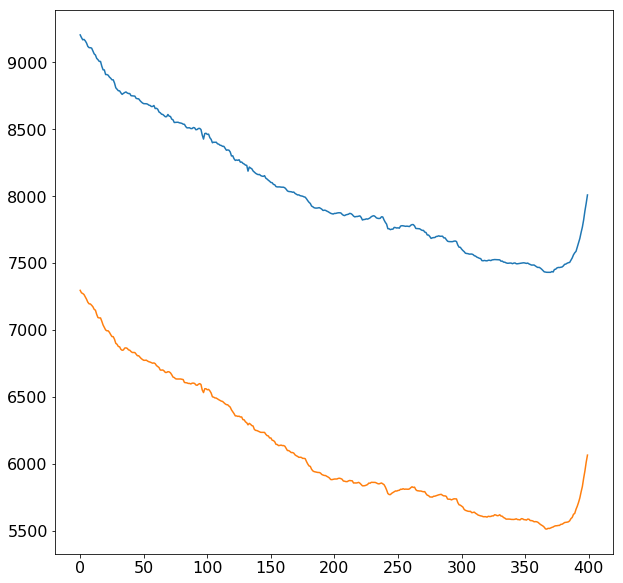

In [25]:
plt.plot(lc_opt_science)
plt.plot(lc_opt_calib)

In [30]:
my_lc = lc_opt_science-lc_opt_calib
my_lc /= np.nanmedian(my_lc)

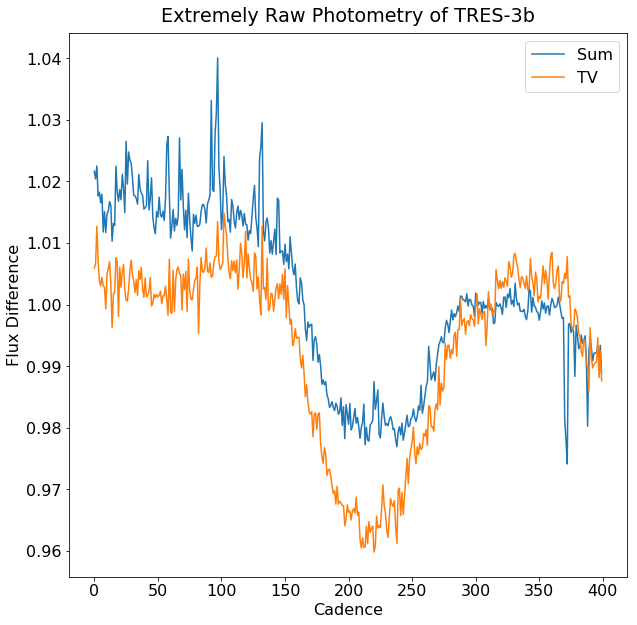

In [33]:
lc = np.sum(tpf,axis=(0,1))
cal = np.sum(tpf_calib,axis=(0,1))
# plt.plot(lc)
# plt.plot(cal)
final = lc-cal
final /= np.nanmedian(final)
plt.plot(2-(final),label="Sum")
plt.plot(2-(my_lc),label="TV")

plt.xlabel("Cadence")
plt.ylabel("Flux Difference")
plt.title("Extremely Raw Photometry of TRES-3b",y=1.01)
plt.legend()
plt.savefig("basic_tres_3b.png")

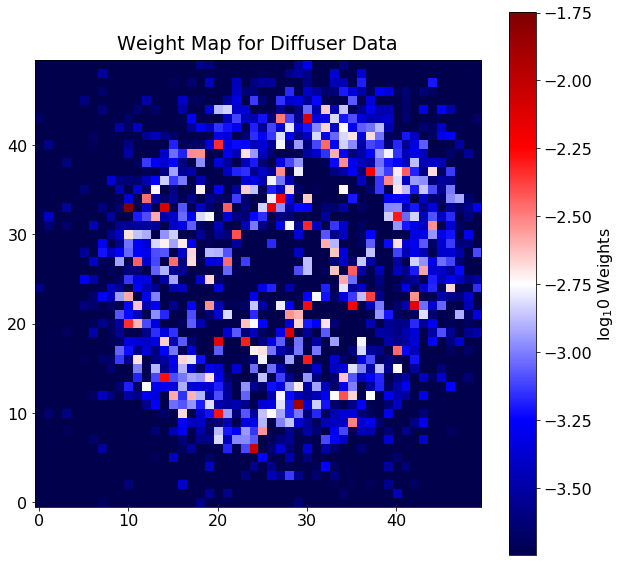

In [39]:
pixelmap = np.zeros((tpf.shape[0],tpf.shape[1]))
m = np.log10(w_best)>-7
pixelmap.ravel()[m] = w_best[m]
cmap = mpl.cm.seismic
weightmap = np.log10(pixelmap)

plt.imshow(weightmap,cmap=cmap, vmin=-2+np.nanmax(weightmap),vmax=np.nanmax(weightmap),
    interpolation='None',origin='lower')

plt.colorbar(label=r"$\log_10$ Weights")
plt.title("Weight Map for Diffuser Data",y=1.01)
plt.savefig('weightmap_diffuser.png')